In [1]:
# Import Transformer Lens, and load pythia models
from transformer_lens import HookedTransformer
import torch as th
from torch import nn
import numpy as np 
from neuron_text_simplifier import NeuronTextSimplifier
from datasets import Dataset, load_dataset
from transformers import AutoTokenizer
from torch.utils.data import DataLoader
from tqdm import tqdm
from einops import rearrange
device = "cuda:1" if th.cuda.is_available() else "cpu"

# model_name = "EleutherAI/pythia-160m-deduped"
MODEL_NAME_LIST = [
    "EleutherAI/pythia-70m-deduped", 
]
model_name = MODEL_NAME_LIST[0]
model_save_name = model_name.replace("/", "-")
layer = 1

model = HookedTransformer.from_pretrained(model_name, device=device)

# tokenizer = AutoTokenizer.from_pretrained(model_name)
Token_amount = 20

# Load the training set from pile-10k
d = load_dataset("NeelNanda/pile-10k", split="train").map(
    lambda x: model.tokenizer(x['text']),
    batched=True,
).filter(
    lambda x: len(x['input_ids']) > Token_amount
).map(
    lambda x: {'input_ids': x['input_ids'][:Token_amount]}
)
neurons = model.W_in.shape[-1]
datapoints = d.num_rows
batch_size = 64

neuron_activations = th.zeros((datapoints*Token_amount, neurons))

try:
    neuron_activations = th.load(f"Data/{model_save_name}_activations_layer_{layer}.pt")
    print("Loaded activations from file")
except:
    with th.no_grad(), d.formatted_as("pt"):
        dl = DataLoader(d["input_ids"], batch_size=batch_size)
        for i, batch in enumerate(tqdm(dl)):
            _, cache = model.run_with_cache(batch.to(device))
            neuron_activations[i*batch_size*Token_amount:(i+1)*batch_size*Token_amount,:] = rearrange(cache[f"blocks.{layer}.mlp.hook_post"], "b s n -> (b s) n" )
    th.save(neuron_activations, f"Data/{model_save_name}_activations_layer_{layer}.pt")

/home/mchorse/miniconda3/envs/logan/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Using pad_token, but it is not set yet.


Loaded pretrained model EleutherAI/pythia-70m-deduped into HookedTransformer


Found cached dataset parquet (/home/mchorse/.cache/huggingface/datasets/NeelNanda___parquet/NeelNanda--pile-10k-72f566e9f7c464ab/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)
Loading cached processed dataset at /home/mchorse/.cache/huggingface/datasets/NeelNanda___parquet/NeelNanda--pile-10k-72f566e9f7c464ab/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec/cache-9b5f9fe88d7bc2e3.arrow
Loading cached processed dataset at /home/mchorse/.cache/huggingface/datasets/NeelNanda___parquet/NeelNanda--pile-10k-72f566e9f7c464ab/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec/cache-81ea955e26446615.arrow
Loading cached processed dataset at /home/mchorse/.cache/huggingface/datasets/NeelNanda___parquet/NeelNanda--pile-10k-72f566e9f7c464ab/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec/cache-000a30dc29ae5636.arrow


Loaded activations from file


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
# import hdbscan

# 1. Given one neuron, find the other neurons that have the most combined activations above a threshold.
def find_most_activated_neurons(neuron, activations, threshold):
    # Filter neurons by activations above the threshold
    activated_neurons = np.where(activations > threshold)

    # Compute activation sums for each neuron
    activation_sums = np.sum(activations[activated_neurons], axis=0)

    # Sort neurons by activation sums and return the indices
    sorted_neurons = np.argsort(activation_sums)[::-1]
    
    return sorted_neurons

# 2. Plot that combination w/ Dbscan labels. maybe HDBSCAN, w/ index & colors
def plot_neurons_with_labels(neurons, activations, labels, method='dbscan'):
    if method == 'dbscan':
        clustering = DBSCAN().fit(activations)
    # elif method == 'hdbscan':
    #     clustering = hdbscan.HDBSCAN().fit(activations)
    else:
        raise ValueError("Invalid method. Use 'dbscan' or 'hdbscan'")

    unique_labels = set(labels)
    colors = plt.cm.Spectral(np.linspace(0, 1, len(unique_labels)))

    for label, color in zip(unique_labels, colors):
        label_indices = np.where(labels == label)
        plt.scatter(neurons[label_indices, 0], neurons[label_indices, 1],
                            c=color, label=label)

    plt.legend()
    plt.show()

In [3]:
# neuron_activations = neuron_activations.cpu().numpy()
threshold = 0.4
neuron = 0
k = 10

mask1 = neuron_activations[:, neuron].where(neuron_activations[:, neuron] > threshold, th.tensor(0.0)) != 0
m2 = neuron_activations[mask1, :].where(neuron_activations[mask1, :] > threshold, th.tensor(0.0)) != 0
v, i = m2.count_nonzero(dim=0).topk(k, largest=True)



# mask2 = neuron_activations.where(neuron_activations[mask1, :] > threshold, th.tensor(0.0)) != 0
# final_mask = combined_masks_of_diff_shape(mask1, mask2)

# def combined_masks_of_diff_shape(mask1, mask2):
#     i = 0
#     for x in range(len(mask1)):
#         if mask1[x]:
#             mask1[x] = th.tensor(mask2[i])
#             i += 1
#     return mask1
# activated_neuron = th.where(neuron_activations[:, neuron] > threshold)[0]
# other_activations = th.where(neuron_activations[activated_neuron] > threshold)

# # # Compute activation sums for each neuron
# activation_sums = th.sum(neuron_activations[other_activations], axis=0)

# # # Sort neurons by activation sums and return the indices
# sorted_neurons = th.argsort(activation_sums)[::-1]

# sorted_neurons

/tmp/ipykernel_2932578/4289903435.py:20: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(activations[label_indices, 0], activations[label_indices, 1],


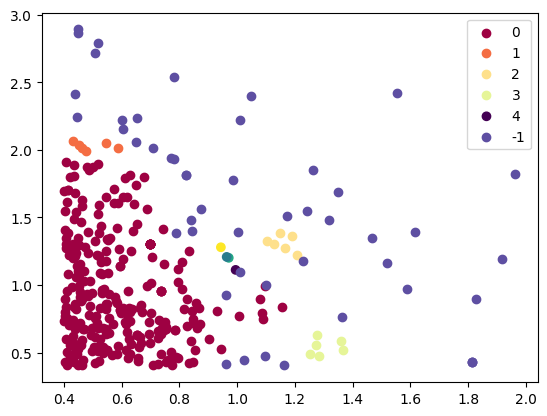

In [4]:
# Plot neurons w/ dbscan labels
# 2. Plot that combination w/ Dbscan labels. maybe HDBSCAN, w/ index & colors
# def plot_neurons_with_labels(neurons, activations, labels, method='dbscan'):
neuron2 = i[1]

eps = 0.1
min_samples = 4
mask_i = neuron_activations[:, neuron2].where(neuron_activations[:, neuron2] > threshold, th.tensor(0.0)) != 0
combined_mask = mask1 & mask_i
activations1 = neuron_activations[combined_mask, neuron]
activations2 = neuron_activations[combined_mask, neuron2]
activations = np.stack((activations1, activations2), axis=1)
clustering = DBSCAN(eps=eps, min_samples=min_samples).fit(activations)
labels =clustering.labels_
unique_labels = set(labels)
colors = plt.cm.Spectral(np.linspace(0, 1, len(unique_labels)))

for label, color in zip(unique_labels, colors):
    label_indices = np.where(labels == label)
    plt.scatter(activations[label_indices, 0], activations[label_indices, 1],
                        c=color, label=label)
plt.legend()
plt.show()

In [9]:
# 2.B Get labels for all neurons within a grid range. Say we just do 4x4 grid
grid = 4
max_x = activations1.max()
max_y = activations2.max()
min_x = activations1.min()
min_y = activations2.min()


array([-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1])

In [5]:
# Look at dataset examples from each cluster
activations.shape

(344, 2)

In [26]:
simplifier = NeuronTextSimplifier(model, layer, neuron)

In [41]:
d_and_seq_points = combined_mask.nonzero()[...,0][label_indices]
value, rel_ind =  neuron_activations[d_and_seq_points, neuron].sort()
label_d_points = (d_and_seq_points // Token_amount)[rel_ind]
token_sequence_pos = (d_and_seq_points % Token_amount)[rel_ind]

/tmp/ipykernel_2932578/601488729.py:3: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  label_d_points = (d_and_seq_points // Token_amount)[rel_ind]


In [42]:
ind

tensor([39, 40, 27, 38, 41, 26, 10, 21,  5,  2, 47, 16, 46, 11, 29, 30, 24, 36,
        23,  7, 12, 48, 42, 22, 28, 33,  0, 43, 20,  9, 31, 45, 14, 25, 34, 32,
        44, 35,  3,  4,  1, 17,  8, 18, 15, 13, 19,  6, 37])

In [43]:
text_list = []
full_text = []
for md, s_ind in zip(label_d_points, token_sequence_pos):
    md = int(md)
    s_ind = int(s_ind)
    full_tok = th.tensor(d[md]["input_ids"])
    full_text.append(model.tokenizer.decode(full_tok))
    
    tok = d[md]["input_ids"][:s_ind+1]
    text = model.tokenizer.decode(tok)
    text_list.append(text)
simplifier.text_to_visualize(text_list, neuron_list=[neuron, neuron2])

In [13]:
d["token_ids"][label_d_points]

KeyError: "Column token_ids not in the dataset. Current columns in the dataset: ['text', 'meta', 'input_ids', 'attention_mask']"

In [8]:
v, i = m2.count_nonzero(dim=0).sort(descending=True)
print("nonzero count: ", v[:10])
print("neuron:        ", i[:10])

nonzero count:  tensor([986, 344, 307, 295, 278, 275, 272, 269, 261, 261])
neuron:         tensor([   0,  512, 1895, 1876, 1435, 2013,  962, 1020,  839,  721])


In [38]:
m2.shape

torch.Size([3286, 2048])

In [31]:
neuron_activations[other_activations].min()

tensor(4.7121)

In [19]:
activated_neuron

tensor([    93,    114,    206,  ..., 199056, 199130, 199155])

In [2]:
corr_coef = th.corrcoef(neuron_activations.T)

In [3]:
print(2048**2)

4194304


In [3]:
neuron = 1306
v, i = corr_coef[neuron, :].sort(descending=True)

In [5]:
for j in range(10):
    neuron_ind = i[j].item()
    print(corr_coef[neuron_ind, :].sort(descending=True).values[:10])

tensor([1306,  924,  697,  503, 1668,  852,  859, 1991,  529, 1646])
tensor([ 924, 1306,  697,  529,  503,  852, 1668,  859,  255, 1991])
tensor([ 697,  924, 1306,  529,  255, 1523,  777,  859,  503, 1449])
tensor([ 503,  859, 1306,  924, 1668,  852, 1991, 1646,  987,   35])
tensor([1668, 1306,  503,  852, 1646,  859,  924, 1200, 1991, 1896])
tensor([ 852, 1991, 1306,  503,  924, 1646, 1668,  859, 1896,  935])
tensor([ 859,  503, 1306, 1668,  924, 1173, 2019,  852, 1177, 1991])
tensor([1991,  852, 1306, 1668,  503,  924, 1646,  859,  935, 1896])
tensor([ 529,  924,  697, 1306,  255, 1449, 1523,  859,  503, 1318])
tensor([1646,  852, 1668,  935, 1991, 1896,  503, 1306,  859,  924])


In [20]:
for j in range(t):
    neuron_ind = i[j].item()
    print(corr_coef[neuron_ind, i[:t]].min().item())

0.362860769033432
0.3111647963523865
0.18492959439754486
0.2608509659767151
0.25849056243896484
0.27204516530036926
0.26944267749786377
0.2639138698577881
0.18532848358154297
0.25123652815818787
0.15140153467655182
0.24702365696430206
0.21995921432971954
0.22950829565525055
0.22643877565860748
0.26466572284698486
0.22175940871238708
0.21319076418876648
0.21186938881874084
0.23599626123905182
0.19811241328716278
0.24938030540943146
0.2179834544658661
0.21676169335842133
0.21654261648654938
0.1911548674106598
0.12188144773244858
0.1997930407524109
0.18377770483493805
0.2042209953069687
0.2179475575685501
0.2298586368560791
0.22150929272174835
0.18167485296726227
0.19090989232063293
0.2189105898141861
0.2413829118013382
0.10247824341058731
0.1726890206336975
0.19885478913784027
0.19096173346042633
0.14983387291431427
0.1877770721912384
0.19545458257198334
0.19559188187122345
0.1390303522348404
0.141532301902771
0.16652655601501465
0.17162717878818512
0.1628270149230957
0.133186474442482
0